# MadMiner physics tutorial (part 2B)

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this with Delphes, in the alternative part 2a we stick to parton level.

## 0. Preparations

Before you execute this notebook, make sure you have working installations of MadGraph, Pythia, and Delphes.

In [1]:
import os
import logging
import numpy as np

from madminer.core import MadMiner
from madminer.delphes import DelphesReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions

In [2]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Please enter here the environment variable pointing to your MG5 installation folder.

In [3]:
#mg_dir = os.getenv("MG_FOLDER_PATH")
mg_dir = "/work/gallim/GenStudies/MG5_aMC_v3_4_1"
os.environ["PYTHIA8DATA"] = "/work/gallim/GenStudies/MG5_aMC_v3_4_1/HEPTools/pythia8/share/Pythia8/xmldoc"

## 1. Generate events

Let's load our setup:

In [4]:
miner = MadMiner()
miner.load("data/setup.h5")

15:28 madminer.utils.inter INFO    HDF5 file does not contain nuisance parameters information
15:28 madminer.utils.inter INFO    HDF5 file does not contain finite difference information
15:28 madminer.utils.inter INFO    HDF5 file does not contain observables information
15:28 madminer.utils.inter INFO    HDF5 file does not contain sample summary information
15:28 madminer.utils.inter INFO    HDF5 file does not contain sample information
15:28 madminer.utils.inter INFO    HDF5 file does not contain systematic information
15:28 madminer.core.madmin INFO    Found 2 parameters:
15:28 madminer.core.madmin INFO       CWL2 (LHA: dim6 2, Power: 2, Range: (-20.0, 20.0))
15:28 madminer.core.madmin INFO       CPWL2 (LHA: dim6 5, Power: 2, Range: (-20.0, 20.0))
15:28 madminer.core.madmin INFO    Found 6 benchmarks:
15:28 madminer.core.madmin INFO       sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:28 madminer.core.madmin INFO       w: CWL2 = 15.20, CPWL2 = 0.10
15:28 madminer.core.madmin INFO       ne

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine at least a few different benchmarks for this option. Here we use the SM and the benchmark "w" that we defined during the setup step.


In [5]:
miner.run(
    sample_benchmark="sm",
    mg_directory=mg_dir,
    mg_process_directory="./mg_processes/signal_pythia",
    proc_card_file="cards/proc_card_signal.dat",
    param_card_template_file="cards/param_card_template.dat",
    pythia8_card_file="cards/pythia8_card.dat",
    configuration_file="cards/me5_configuration.txt",
    run_card_file="cards/run_card_signal_small.dat",
    log_directory="logs/signal",
    python_executable="python3",
)

15:28 madminer.core.madmin INFO    Adding python3 bin folder to PATH
15:28 madminer.core.madmin INFO    Using Python executable /work/gallim/anaconda3/envs/MadMiner/bin/python3
15:28 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal_pythia
15:28 madminer.utils.inter INFO    Calling MadGraph: export PATH=/work/gallim/anaconda3/envs/MadMiner/bin:$PATH; python3 /work/gallim/GenStudies/MG5_aMC_v3_4_1/bin/mg5_aMC /tmp/generate.mg5
15:28 madminer.core.madmin INFO    Run 0
15:28 madminer.core.madmin INFO      Sampling from benchmark: sm
15:28 madminer.core.madmin INFO      Original run card:       cards/run_card_signal_small.dat
15:28 madminer.core.madmin INFO      Original Pythia8 card:   cards/pythia8_card.dat
15:28 madminer.core.madmin INFO      Original config card:    cards/me5_configuration.txt
15:28 madminer.core.madmin INFO      Copied run card:         madminer/cards/run_card_0.dat
15:28 madminer.core.madmin INFO 

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [6]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background_pythia',
    proc_card_file='cards/proc_card_background.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

"\nminer.run(\n    is_background=True,\n    sample_benchmark='sm',\n    mg_directory=mg_dir,\n    mg_process_directory='./mg_processes/background_pythia',\n    proc_card_file='cards/proc_card_background.dat',\n    pythia8_card_file='cards/pythia8_card.dat',\n    param_card_template_file='cards/param_card_template.dat',\n    run_card_file='cards/run_card_background.dat',\n    log_directory='logs/background',\n)\n"

Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Run Delphes

The `madminer.delphes.DelphesReader` class wraps around Delphes, a popular fast detector simulation, to simulate the effects of the detector.

In [7]:
delphes = DelphesReader("data/setup.h5")

15:35 madminer.utils.inter INFO    HDF5 file does not contain nuisance parameters information
15:35 madminer.utils.inter INFO    HDF5 file does not contain finite difference information
15:35 madminer.utils.inter INFO    HDF5 file does not contain observables information
15:35 madminer.utils.inter INFO    HDF5 file does not contain sample summary information
15:35 madminer.utils.inter INFO    HDF5 file does not contain sample information
15:35 madminer.utils.inter INFO    HDF5 file does not contain systematic information


After creating the `DelphesReader` object, one can add a number of event samples (the output of running MadGraph and Pythia in step 1 above) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [8]:
delphes.add_sample(
    lhe_filename="mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz",
    hepmc_filename="mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz",
    sampled_from_benchmark="sm",
    is_background=False,
    k_factor=1.1,
)

"""
delphes.add_sample(
    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""

15:35 madminer.delphes.del DEBUG   Adding event sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz


"\ndelphes.add_sample(\n    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',\n    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

Now we run Delphes on these samples (you can also do this externally and then add the keyword `delphes_filename` when calling `DelphesReader.add_sample()`):

In [9]:
delphes.run_delphes(
    delphes_directory=mg_dir + "/Delphes",
    delphes_card="cards/delphes_card.dat",
    log_file="logs/delphes.log",
)

15:35 madminer.delphes.del INFO    Running Delphes on HepMC sample at mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
15:35 madminer.utils.inter DEBUG   Unzipping mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
15:36 madminer.utils.inter DEBUG   Deleting mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc


## 3. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [10]:
delphes.add_observable(
    "pt_j1",
    "j[0].pt",
    required=False,
    default=0.0,
)
delphes.add_observable(
    "delta_phi_jj",
    "j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))",
    required=True,
)
delphes.add_observable(
    "met",
    "met.pt",
    required=True,
)

15:37 madminer.delphes.del DEBUG   Adding optional observable pt_j1 = j[0].pt with default 0.0
15:37 madminer.delphes.del DEBUG   Adding required observable delta_phi_jj = j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))
15:37 madminer.delphes.del DEBUG   Adding required observable met = met.pt


We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [11]:
delphes.add_cut("(a[0] + a[1]).m > 122.")
delphes.add_cut("(a[0] + a[1]).m < 128.")
delphes.add_cut("pt_j1 > 20.")

15:38 madminer.delphes.del DEBUG   Adding cut (a[0] + a[1]).m > 122.
15:38 madminer.delphes.del DEBUG   Adding cut (a[0] + a[1]).m < 128.
15:38 madminer.delphes.del DEBUG   Adding cut pt_j1 > 20.


## 4. Analyse events and store data

The function `analyse_samples` then calculates all observables from the Delphes file(s) generated before and checks which events pass the cuts:

In [12]:
delphes.analyse_delphes_samples()

15:38 madminer.delphes.del INFO    Analysing Delphes sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root: Calculating 3 observables, requiring 3 selection cuts, associated with no systematics
15:38 madminer.delphes.del DEBUG   Extracting nuisance parameter definitions from LHE file
15:38 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz
15:38 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
15:38 madminer.utils.inter DEBUG   1 weight groups
15:38 madminer.delphes.del DEBUG   systematics_dict: OrderedDict()
15:38 madminer.utils.inter DEBUG   Parsing Delphes file mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root
15:38 madminer.utils.inter DEBUG   Not extracting weights
15:38 madminer.utils.inter DEBUG   Found 10000 events
15:38 madminer.utils.inter DEBUG     First 10 values for observable pt_j1:
[ 69.16579437 113.53088379 162.1

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [13]:
delphes.save("data/delphes_data.h5")

15:40 madminer.delphes.del DEBUG   Loading HDF5 data from data/setup.h5 and saving file to data/delphes_data.h5
15:40 madminer.delphes.del DEBUG   Weight names: ['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5']
15:40 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in the list of benchmarks
15:40 madminer.utils.inter DEBUG   Benchmark neg_w already in the list of benchmarks
15:40 madminer.utils.inter DEBUG   Benchmark neg_ww already in the list of benchmarks
15:40 madminer.utils.inter DEBUG   Benchmark sm already in the list of benchmarks
15:40 madminer.utils.inter DEBUG   Benchmark w already in the list of benchmarks
15:40 madminer.utils.inter DEBUG   Benchmark ww already in the list of benchmarks
15:40 madminer.utils.inter DEBUG   Weight names to save in event file: odict_keys(['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5'])
15:40 madminer.utils.inter DEBUG   Benchmark names to save in event file: ['sm', 'w', 'neg_w', 'ww', 'neg_ww'

## 5. Plot distributions

Let's see what our MC run produced:

15:40 madminer.analysis.da INFO    Loading data from data/delphes_data.h5
15:40 madminer.utils.inter INFO    HDF5 file does not contain nuisance parameters information
15:40 madminer.utils.inter INFO    HDF5 file does not contain finite difference information
15:40 madminer.utils.inter INFO    HDF5 file does not contain systematic information
15:40 madminer.analysis.da INFO    Found 2 parameters
15:40 madminer.analysis.da INFO      0: CWL2 (LHA: dim6 2, Power: 2, Range: (-20.0, 20.0))
15:40 madminer.analysis.da INFO      1: CPWL2 (LHA: dim6 5, Power: 2, Range: (-20.0, 20.0))
15:40 madminer.analysis.da INFO    Did not find nuisance parameters
15:40 madminer.analysis.da INFO    Found 6 benchmarks
15:40 madminer.analysis.da DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40 madminer.analysis.da DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
15:40 madminer.analysis.da DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
15:40 madminer.analysis.da DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
15:40 m

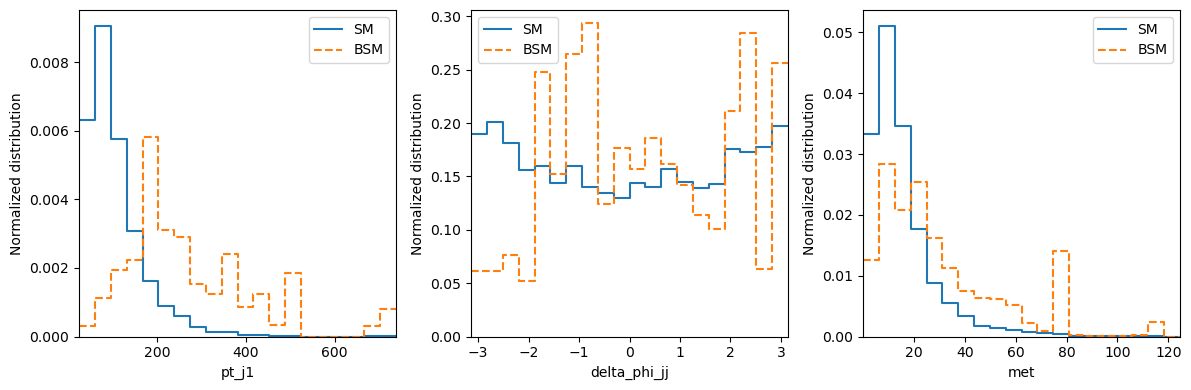

In [14]:
_ = plot_distributions(
    filename="data/delphes_data.h5",
    parameter_points=["sm", np.array([10.0, 0.0])],
    line_labels=["SM", "BSM"],
    uncertainties="none",
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 6. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [15]:
combine_and_shuffle(["data/delphes_data.h5"], "data/delphes_data_shuffled.h5")

15:41 madminer.sampling.co DEBUG   Combining and shuffling samples
15:41 madminer.sampling.co DEBUG   Copying setup from data/delphes_data.h5 to data/delphes_data_shuffled.h5
15:41 madminer.sampling.co DEBUG   Loading samples from file 1 / 1 at data/delphes_data.h5, multiplying weights with k factor 1.0
15:41 madminer.utils.inter INFO    HDF5 file does not contain nuisance parameters information
15:41 madminer.utils.inter INFO    HDF5 file does not contain finite difference information
15:41 madminer.utils.inter INFO    HDF5 file does not contain systematic information
15:41 madminer.sampling.co DEBUG   Sampling benchmarks: [0 0 0 ... 0 0 0]
15:41 madminer.sampling.co DEBUG   Combined sampling benchmarks: [0 0 0 ... 0 0 0]
15:41 madminer.sampling.co DEBUG   Recalculated event numbers per benchmark: [4190    0    0    0    0    0], background: 0
